# Module: Interpolation routines for SSP

> Lookup table or interpolation for Simple stellar population (SSPs)

In [ ]:
#| default_exp ssp_interpolation

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np

In [ ]:
#| export

def spec_ssp_lookup_nearest(age_hydro_i:np.float32=None, # Age of the HACC stellar particle
             metal_hydro_i:np.float32=None, # Metallicity of the stellar particle
             mass_hydro_i:np.float32=None, # Mass of the stellar particle
             age_fsps:np.float32=None, # Ages in SPS library
             z_padova_fsps:np.float32=None, # Metallicities in SPS library
             spec_flux:np.array=None, # Stellar library SEDs 
             spec_wave:np.array=None, # Stellar library wavelengths
            )-> tuple: # SSP Wavelength (A), SSP Luminosity (Lsun/A)
    '''
    Lookup table for finding the closest SPS entry to HACC SSP
    '''
    # https://ned.ipac.caltech.edu/level5/Sept14/Conroy/Conroy2.html
    
    age_index = np.argmin(np.abs(age_fsps-age_hydro_i))
    met_index = np.argmin(np.abs(z_padova_fsps-metal_hydro_i))
    # print(age_index, met_index)
    # spec_flux_i = 1e10*mass_hydro_i*spec_flux[met_index, age_index]  ## Not sure where 1e10 factor is from. Will ignore for now
    spec_flux_i = mass_hydro_i*spec_flux[met_index, age_index]
    
    return spec_wave, spec_flux_i

In [ ]:
#| export

def spec_ssp_lookup(age_hydro_i:np.float32=None, # Age of the HACC stellar particle
             metal_hydro_i:np.float32=None, # Metallicity of the stellar particle
             mass_hydro_i:np.float32=None, # Mass of the stellar particle
             age_fsps:np.float32=None, # Ages in SPS library
             z_padova_fsps:np.float32=None, # Metallicities in SPS library
             spec_flux:np.array=None, # Stellar library SEDs 
             spec_wave:np.array=None, # Stellar library wavelengths
            )-> tuple: # SSP Wavelength (A), SSP Luminosity (Lsun/A)
    '''
    Interpolation for finding the closest SPS entry to HACC SSP
    '''
    # https://ned.ipac.caltech.edu/level5/Sept14/Conroy/Conroy2.html
    
    
    age_diff = np.abs(age_fsps-age_hydro_i)
    metal_diff = np.abs(z_padova_fsps-metal_hydro_i)

    age_index = np.argsort(age_diff)
    met_index = np.argsort(metal_diff)
    
    
    age_min = np.min([age_index[1], age_index[0]])
    met_min = np.min([met_index[1], met_index[0]])
    
    age_diff_grid = np.abs(age_fsps[age_min + 1] - age_fsps[age_min])
    metal_diff_grid = np.abs(z_padova_fsps[met_min + 1] - z_padova_fsps[met_min])
    diff_denom = age_diff_grid*metal_diff_grid
    
    age_0 = np.abs(age_fsps[age_min] - age_hydro_i)
    met_0 = np.abs(z_padova_fsps[met_min] - metal_hydro_i)
    
    
    spec_flux_00 = spec_flux[met_min, age_min] 
    spec_flux_01 = spec_flux[met_min, age_min + 1] 
    spec_flux_10 = spec_flux[met_min + 1, age_min] 
    spec_flux_11 = spec_flux[met_min + 1, age_min + 1] 
    
    w00 = (1-age_0)*(1-met_0)
    w01 = (1-age_0)*met_0
    w10 = age_0*(1-met_0)
    w11 = age_0*met_0
    
    w00 = w00/diff_denom
    w01 = w01/diff_denom
    w10 = w10/diff_denom
    w11 = w11/diff_denom
    
    print(age_min, met_min)
    
    spec_flux_i = (w00*spec_flux_00) + (w01*spec_flux_01) + (w10*spec_flux_10) + (w11*spec_flux_11)
    
    spec_flux_i_mass_weighted = mass_hydro_i*spec_flux_i
    ## Not sure where 1e10 factor was from. Will ignore for now
    
    return spec_wave, spec_flux_i_mass_weighted

In [ ]:
#| hide

import matplotlib.pylab as plt
from watercolor.load_sps_library import *
from watercolor.load_sim_stellar_catalog import *

Text(0.5, 0, 'age')

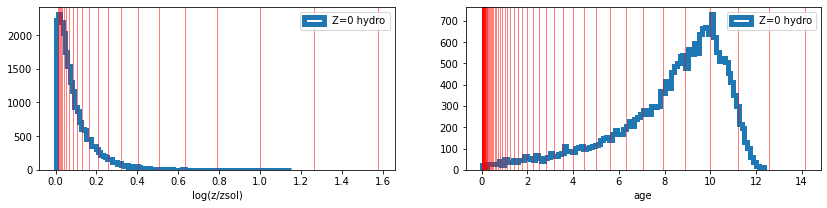

In [ ]:
#| hide

spec_flux, spec_wave = load_fsps_spectral_library()

age_fsps_gyr, Z_padova_fsps = load_fsps_age_metallicity()

fof_halo_tag, if_satellite, gal_tag, stellar_idx, metal_hydro, mass, age_hydro, x, y, z, vx, vy, vz = load_hacc_galaxy_data()


f, a = plt.subplots(1,2, figsize=(14, 3))
a[0].hist(metal_hydro, bins = 100, histtype='step', lw=5, label='Z=0 hydro');
[a[0].axvline(_x, linewidth=1, color='r', alpha=0.5) for _x in Z_padova_fsps];
a[0].legend()
a[0].set_xlabel('log(z/zsol)')


a[1].hist(age_hydro, bins = 100, histtype='step', lw=5, label='Z=0 hydro');
[a[1].axvline(_x, linewidth=1, color='r', alpha=0.5) for _x in age_fsps_gyr];
a[1].legend()
a[1].set_xlabel('age')

# plt.savefig('Plots/metal_mass_dist_hydro.png')

Text(0, 0.5, 'age')

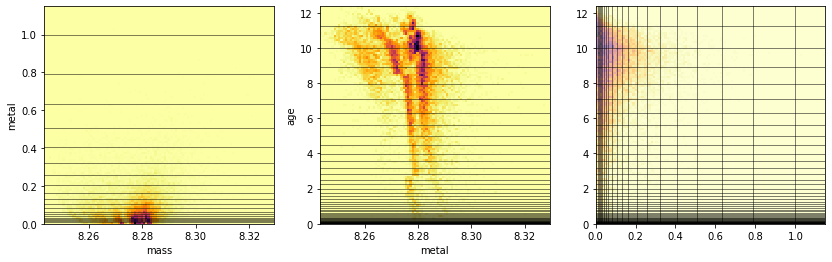

In [ ]:
#| hide 

f, a = plt.subplots(1, 3, figsize=(14, 4))

cmap = plt.get_cmap('inferno_r')
plt.set_cmap(cmap)

a[0].hist2d(np.log10(mass), metal_hydro, bins = 100);
[a[0].axhline(_x, linewidth=1, color='k', alpha=0.5) for _x in Z_padova_fsps];
a[0].set_xlabel('mass')
a[0].set_ylabel('metal')

a[1].hist2d(np.log10(mass), age_hydro, bins = 100);
[a[1].axhline(_x, linewidth=1, color='k', alpha=0.5) for _x in age_fsps_gyr];

a[1].set_xlabel('mass')
a[1].set_ylabel('age')


a[2].hist2d(metal_hydro, age_hydro, bins = 100, alpha=0.5);
[a[2].axvline(_x, linewidth=1, color='k', alpha=0.5) for _x in Z_padova_fsps];
[a[2].axhline(_x, linewidth=1, color='k', alpha=0.5) for _x in age_fsps_gyr];

a[1].set_xlabel('metal')
a[1].set_ylabel('age')

# a[2].set_yscale('log')

In [ ]:
#| hide

ssp_id = 224

spec_wave_ssp, spec_flux_ssp = spec_ssp_lookup(age_hydro[ssp_id], 
             metal_hydro[ssp_id], 
             mass[ssp_id],
             age_fsps_gyr,
             Z_padova_fsps,
             spec_flux,
             spec_wave)

89 6


Text(0, 0.5, '$L_{\\rm CSP}(\\lambda)\\ {\\rm [L_{\\odot}/\\AA]}$')

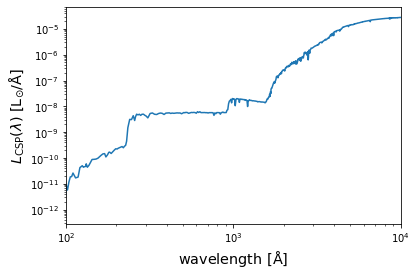

In [ ]:
#| hide

plt.figure()
plt.plot(spec_wave_ssp, spec_flux_ssp)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2, 1e4)
plt.xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
plt.ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()